In [50]:
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import numpy as np
from qiskit.quantum_info import Operator, Pauli
from qiskit.circuit.library import QFT
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import Z2Symmetries, X, Y, Z, I
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import SparsePauliOp
from qiskit import IBMQ, BasicAer, Aer
from qiskit import IBMQ
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit.library import RealAmplitudes, TwoLocal
#from qiskit.aqua.components.initial_states import VarFormBased, Custom
# Import useful packages


from qiskit.tools.visualization import circuit_drawer
import matplotlib
import matplotlib.pyplot as plt
import matplotlib
import pylab
import numpy as np
import os
from datetime import datetime
#IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
backend_stv = Aer.get_backend('statevector_simulator')
backend_qsm = Aer.get_backend('qasm_simulator')
backend_manil = provider.get_backend('ibmq_manila')
#backend_qsm_ibm=provider.get_backend('ibmq_qasm_simulator')
sh=1024
npme = NumPyMinimumEigensolver()


In [22]:
provider.backends(simulator=False, operational=True)

[<IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [96]:
q=5 #qubits
n=2**q #dimension
coup=0.1 #coupling
alpha=coup/(np.math.factorial(3)) #cubic coupling
#alpha=coup/3
beta=coup/(np.math.factorial(4)) #quartic coupling
#beta=coup/4

#Ladder operator and identity
a = np.zeros(shape=(n,n)).astype(complex)
idt= np.zeros(shape=(n,n)).astype(complex)

for i in range(n):
    for j in range(n):
        if j==i+1:
            a[i][j]=np.sqrt(i)
for i in range(n):
    for j in range(n):
        if j==i:
            idt[i][j]=1
a_dag=a.conj().T

XE=(np.sqrt(1/2))*(a_dag+a) #Position Operator
PE=complex(0,np.sqrt(1/2))*(a.conj().T-a) #Momentum Operator
HOE=np.matmul(a_dag,a) +(1/2)*idt #Harmonic Oscillator
CAHOE=np.matmul(a_dag,a) + ((1/2)*idt) - alpha*np.linalg.matrix_power(XE,3) # Cubic Anaharmonic Oscillator
QAHOE=np.matmul(a_dag,a) + ((1/2)*idt) + beta*np.linalg.matrix_power(XE,4) #Quartic Anaharmonic Oscillator

HOE_OP=Operator(HOE) #Qiskit operators
CAHOE_OP=Operator(CAHOE)
QAHOE_OP=Operator(QAHOE)

P_HOE_OP=PauliSumOp(SparsePauliOp.from_operator(HOE_OP),coeff=1.0) #PauliSum OPs
P_CAHOE_OP=PauliSumOp(SparsePauliOp.from_operator(CAHOE_OP),coeff=1.0)
P_QAHOE_OP=PauliSumOp(SparsePauliOp.from_operator(QAHOE_OP),coeff=1.0)
np.linalg.det(HOE)

(4.149395946087054e+32+0j)

In [6]:
#Variatonal Forms
def Var_form_set(q,d,ent,cont):
    if cont==1:
        vf_TL = TwoLocal(
            num_qubits=q,
            reps=d,
            rotation_blocks=['ry','rz'],
            entanglement_blocks='cx',
            entanglement=ent,
            )
        return vf_TL
    vf_RA=RealAmplitudes(
        num_qubits=q,
        reps=d,
        entanglement=ent,
        )
    return vf_RA

In [7]:
vf=Var_form_set(q,1,'linear',0)
print(vf.decompose())

     ┌──────────┐     ┌──────────┐                                    
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[5]) ├────────────────────────────────────
     ├──────────┤┌─┴─┐└──────────┘┌──────────┐                        
q_1: ┤ Ry(θ[1]) ├┤ X ├─────■──────┤ Ry(θ[6]) ├────────────────────────
     ├──────────┤└───┘   ┌─┴─┐    └──────────┘┌──────────┐            
q_2: ┤ Ry(θ[2]) ├────────┤ X ├─────────■──────┤ Ry(θ[7]) ├────────────
     ├──────────┤        └───┘       ┌─┴─┐    └──────────┘┌──────────┐
q_3: ┤ Ry(θ[3]) ├────────────────────┤ X ├─────────■──────┤ Ry(θ[8]) ├
     ├──────────┤                    └───┘       ┌─┴─┐    ├──────────┤
q_4: ┤ Ry(θ[4]) ├────────────────────────────────┤ X ├────┤ Ry(θ[9]) ├
     └──────────┘                                └───┘    └──────────┘


VQE Results: [0.5065794206242589, 0.501167578879448, 0.7851558122126423, 1.0217857598713098, 1.648209174881468, 0.5246090539453155]
Exact Result: 0.50000


Runtime: 0:00:03.547016
Runtime for loop 1 : 0:00:00.614489
Runtime for loop 2 : 0:00:00.550450
Runtime for loop 3 : 0:00:00.542939
Runtime for loop 4 : 0:00:00.671683
Runtime for loop 5 : 0:00:00.569924
Runtime for loop 6 : 0:00:00.587687


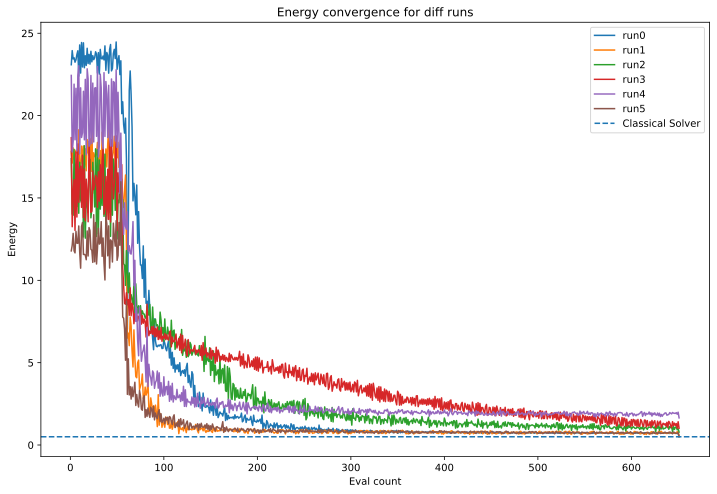

In [97]:
#QHO Statevector simulator 1 reps; 2000 trials.
begin = datetime.now()

seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(backend_stv, seed_transpiler=seed, seed_simulator=seed)
runs=6

vqe_energies=[]
Runtimes=[]
conv_cnts = np.empty(runs, dtype=object)
conv_vals = np.empty(runs, dtype=object)

for i in range(runs):
    beginl = datetime.now()
    vf=Var_form_set(q,1,'linear',0)
    optimizer = SPSA(maxiter=300)
   

    counts=[]
    values=[]
    def callback(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    vqe = VQE(vf, optimizer,quantum_instance=qi,callback=callback)
    vqe_result=vqe.compute_minimum_eigenvalue(operator=P_HOE_OP)
    vqe_eigenv=vqe_result.eigenvalue.real
    vqe_energies.append(vqe_eigenv)
    conv_cnts[i] = np.asarray(counts)
    conv_vals[i] = np.asarray(values)
    
    endl = datetime.now()
    Runtimes.append(endl-beginl)
print("VQE Results:", vqe_energies)
exact_solution = npme.compute_minimum_eigenvalue(operator=P_HOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

end = datetime.now()
print("\n")
print ("Runtime:",end-begin)
for i in range(runs):
    print ("Runtime for loop",i+1,":",Runtimes[i])
    
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(runs):
    pylab.plot(conv_cnts[i], conv_vals[i], label='run'+str(i))
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for diff runs')
pylab.legend(loc='upper right');

/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


VQE Results: [0.5081102248688879, 0.5007602264722962, 0.8171909406810514]
Exact Result: 0.49962


Runtime: 0:00:01.944293
Runtime for loop 1 : 0:00:00.604837
Runtime for loop 2 : 0:00:00.633718
Runtime for loop 3 : 0:00:00.664291


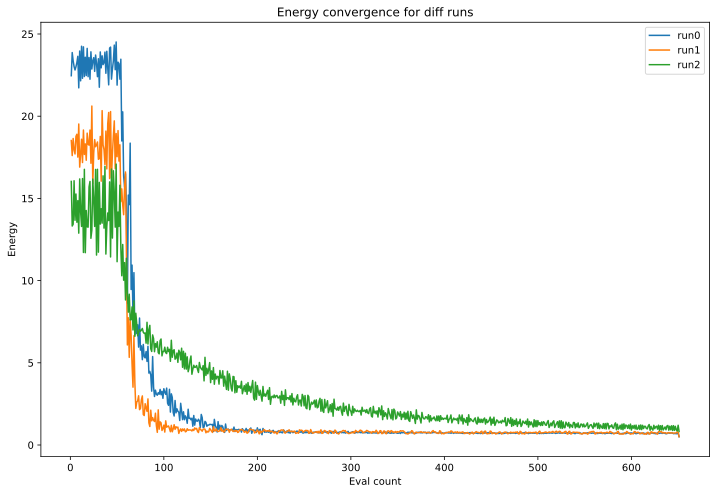

In [59]:
#CQAHO Statevector simulator 1 reps; 2000 trials.
begin = datetime.now()

seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(backend_stv, seed_transpiler=seed, seed_simulator=seed)
runs=3

vqe_energies=[]
Runtimes=[]
conv_cnts = np.empty(runs, dtype=object)
conv_vals = np.empty(runs, dtype=object)

for i in range(runs):
    beginl = datetime.now()
    vf=Var_form_set(q,1,'linear',0)
    optimizer = SPSA(maxiter=300)
   

    counts=[]
    values=[]
    def callback(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    vqe = VQE(vf, optimizer,quantum_instance=qi,callback=callback)
    vqe_result=vqe.compute_minimum_eigenvalue(operator=P_CAHOE_OP)
    vqe_eigenv=vqe_result.eigenvalue.real
    vqe_energies.append(vqe_eigenv)
    conv_cnts[i] = np.asarray(counts)
    conv_vals[i] = np.asarray(values)
    
    endl = datetime.now()
    Runtimes.append(endl-beginl)
print("VQE Results:", vqe_energies)
exact_solution = npme.compute_minimum_eigenvalue(operator=P_CAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

end = datetime.now()
print("\n")
print ("Runtime:",end-begin)
for i in range(runs):
    print ("Runtime for loop",i+1,":",Runtimes[i])
    
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(runs):
    pylab.plot(conv_cnts[i], conv_vals[i], label='run'+str(i))
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for diff runs')
pylab.legend(loc='upper right');

/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


VQE Results: [0.506736833147696, 0.5047332876909835, 0.6576146069364722]
Exact Result: 0.50000


Runtime: 0:00:01.854017
Runtime for loop 1 : 0:00:00.629024
Runtime for loop 2 : 0:00:00.620550
Runtime for loop 3 : 0:00:00.555182


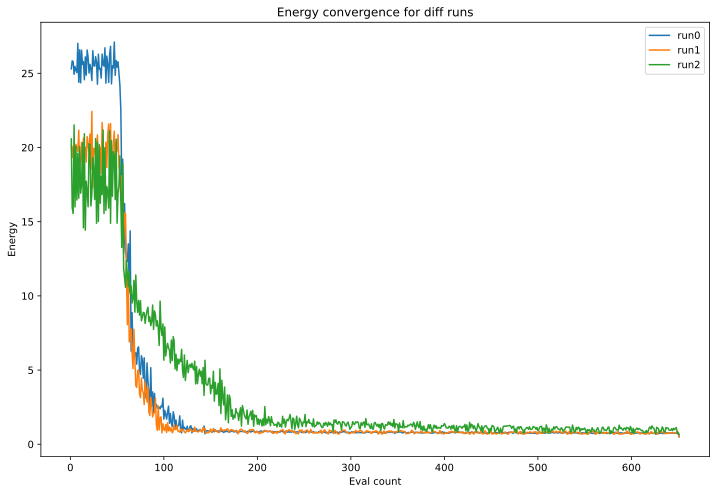

In [63]:
#QQAHO Statevector simulator 1 reps; 2000 trials.
begin = datetime.now()

seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(backend_stv, seed_transpiler=seed, seed_simulator=seed)
runs=3

vqe_energies=[]
Runtimes=[]
conv_cnts = np.empty(runs, dtype=object)
conv_vals = np.empty(runs, dtype=object)

for i in range(runs):
    beginl = datetime.now()
    vf=Var_form_set(q,1,'linear',0)
    optimizer = SPSA(maxiter=300)
   

    counts=[]
    values=[]
    def callback(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    vqe = VQE(vf, optimizer,quantum_instance=qi,callback=callback)
    vqe_result=vqe.compute_minimum_eigenvalue(operator=P_QAHOE_OP)
    vqe_eigenv=vqe_result.eigenvalue.real
    vqe_energies.append(vqe_eigenv)
    conv_cnts[i] = np.asarray(counts)
    conv_vals[i] = np.asarray(values)
    
    endl = datetime.now()
    Runtimes.append(endl-beginl)
print("VQE Results:", vqe_energies)
exact_solution = npme.compute_minimum_eigenvalue(operator=P_QAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

end = datetime.now()
print("\n")
print ("Runtime:",end-begin)
for i in range(runs):
    print ("Runtime for loop",i+1,":",Runtimes[i])
    
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(runs):
    pylab.plot(conv_cnts[i], conv_vals[i], label='run'+str(i))
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for diff runs')
pylab.legend(loc='upper right');

In [132]:
#Statevector simulator 3 reps; 2000 trials.
begin = datetime.now()

seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(backend_stv, seed_transpiler=seed, seed_simulator=seed)

vqe_energies=[]
Runtimes=[]
for i in range(10):
    beginl = datetime.now()
    vf=Var_form_set(q,3,'linear',0)
    optimizer = SPSA(maxiter=2000)
    vqe = VQE(vf, optimizer,quantum_instance=qi)
    vqe_result=vqe.compute_minimum_eigenvalue(operator=OPS)
    vqe_eigenv=vqe_result.eigenvalue.real
    vqe_energies.append(vqe_eigenv)
    endl = datetime.now()
    Runtimes.append(endl-beginl)
print("VQE Results:", vqe_energies)
exact_solution = npme.compute_minimum_eigenvalue(operator=OPS)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

end = datetime.now()
print("\n")
print ("Runtime:",end-begin)
for i in range(10):
    print ("Runtime for loop",i+1,":",Runtimes[i])

VQE Results: [0.5097241164353732, 0.5035449010384992, 0.5966606627545504, 0.5714258868167638, 1.213639322935794, 0.5217622265293239, 0.6061870769922939, 0.5176074063282737, 0.5855275676406357, 0.9331156602543957]
Exact Result: 0.50000


Runtime: 0:03:24.708961
Runtime for loop 1 : 0:00:20.373465
Runtime for loop 2 : 0:00:20.622127
Runtime for loop 3 : 0:00:20.677857
Runtime for loop 4 : 0:00:20.681517
Runtime for loop 5 : 0:00:19.521968
Runtime for loop 6 : 0:00:20.894771
Runtime for loop 7 : 0:00:20.076867
Runtime for loop 8 : 0:00:20.125050
Runtime for loop 9 : 0:00:20.690805
Runtime for loop 10 : 0:00:21.038387


In [154]:
#Statevector simulator 3 reps; 2000 trials.

begin = datetime.now()

vqe_energies=[]
Runtimes=[]
for i in range(10):
    beginl = datetime.now()
    vf=Var_form_set(q,3,'linear',0)
    optimizer = SPSA(max_trials=2000)
    vqe = VQE(PM1,vf, optimizer)
    vqe_result = vqe.run(backend_stv)
    vqe_eigenv=np.real(vqe_result['eigenvalue'])
    vqe_energies.append(vqe_eigenv)
    endl = datetime.now()
    Runtimes.append(endl-beginl)
print("VQE Results:", vqe_energies)
exact_solution = NumPyEigensolver(PM1,k=1).run()
print("Exact Result:", np.real(exact_solution.eigenvalues))

end = datetime.now()
print("\n")
print ("Runtime:",end-begin)
for i in range(10):
    print ("Runtime for loop",i+1,":",Runtimes[i])

VQE Results: [1.19705301124189, 0.50800509209793, 0.57721428892671, 0.5260098443837, 0.52000086971835, 1.32995574841291, 1.50148430550188, 0.52171893134381, 0.545481040121, 0.60024485668245]
Exact Result: [0.5]


Runtime: 0:12:20.928008
Runtime for loop 1 : 0:01:12.660101
Runtime for loop 2 : 0:01:12.991545
Runtime for loop 3 : 0:01:14.790987
Runtime for loop 4 : 0:01:19.284885
Runtime for loop 5 : 0:01:11.487468
Runtime for loop 6 : 0:01:11.835135
Runtime for loop 7 : 0:01:12.074968
Runtime for loop 8 : 0:01:13.925298
Runtime for loop 9 : 0:01:12.860576
Runtime for loop 10 : 0:01:18.986818


In [150]:
vqe_result

{'optimal_parameters': {Parameter(θ[0]): -0.01967359730037374, Parameter(θ[10]): 0.49739928691891894, Parameter(θ[11]): 0.03718453628868251, Parameter(θ[12]): 1.9194142539339192, Parameter(θ[13]): -4.7923757293002245, Parameter(θ[14]): 1.563669360212396, Parameter(θ[15]): -1.571356016339995, Parameter(θ[16]): -4.529921844233582, Parameter(θ[17]): 3.322750756138597, Parameter(θ[18]): -0.4001422960485747, Parameter(θ[19]): -2.1525212448703748, Parameter(θ[1]): -3.138933720278665, Parameter(θ[20]): -1.5810081430069098, Parameter(θ[21]): -0.5074617579180594, Parameter(θ[22]): 3.353907824622781, Parameter(θ[23]): 1.7540549828085095, Parameter(θ[2]): 3.023728996360755, Parameter(θ[3]): 1.2061862887666404, Parameter(θ[4]): -4.710675000377457, Parameter(θ[5]): 1.5707425458971673, Parameter(θ[6]): -1.9286480055665611, Parameter(θ[7]): -1.931683298986307, Parameter(θ[8]): 0.4488113432834966, Parameter(θ[9]): -4.338857537053138}, 'optimal_point': array([-0.0196736 ,  0.49739929,  0.03718454,  1.9

In [93]:
#Simulated noise 1 rep; 1000 trial
C_map=backend_melb.configuration().coupling_map
noise_model=NoiseModel.from_backend(backend_melb.properties())
melb_qsm_instance=QuantumInstance(backend_qsm,shots=sh,
                                  noise_model=noise_model,
                                  coupling_map=C_map,
                                  measurement_error_mitigation_cls=CompleteMeasFitter,
                                  cals_matrix_refresh_period=30
                                  )

vqe_energies=[]
vqe = VQE(PM1,vf , optimizer)
for i in range(10):
    optimizer = SPSA(max_trials=1000)
    vf=Var_form_set(q,1,'linear',0)
    vqe = VQE(PM1,vf , optimizer)
    vqe_result = np.real(vqe.run(melb_qsm_instance)['eigenvalue'])
    vqe_energies.append(vqe_result)
print("VQE Results:", vqe_energies)
exact_solution = NumPyEigensolver(PM1,k=1).run()
print("Exact Result:", np.real(exact_solution.eigenvalues))

VQE Results: [3.1669960934701, 2.48162518624638, 4.33238510305513, 4.6849388179576, 3.57811831303008, 3.26018656899288, 2.52444441253122, 2.613130568577, 2.50602705311393, 2.67705174978006]
Exact Result: [0.5]


In [104]:
#Real device 1rep; 1 trial
melb_instance=QuantumInstance(backend_melb,shots=sh,skip_qobj_validation=False, optimization_level=3)

begin = datetime.now()
print ("Start date and time : ")
print (begin.strftime("%Y-%m-%d %H:%M:%S"))

optimizer = SPSA(max_trials=1)
vf=Var_form_set(q,1,'linear',0)
vqe = VQE(PM1,vf, optimizer)

vqe_result = np.real(vqe.run(melb_instance)['eigenvalue'])
print("VQE Results:", vqe_result)
exact_solution = NumPyEigensolver(PM1,k=1).run()
print("Exact Result:", np.real(exact_solution.eigenvalues))

end = datetime.now()
print ("End date and time : ")
print (end.strftime("%Y-%m-%d %H:%M:%S"))
print ("Runtime:",end-begin)

Start date and time : 
2020-05-22 13:29:58
VQE Results: 26.30078125
Exact Result: [0.5]
End date and time : 
2020-05-22 13:44:25
Runtime: 0:14:26.088888


In [100]:
#IBM QASM,noise 1 rep, 5000 trials
C_map=backend_melb.configuration().coupling_map
noise_model=NoiseModel.from_backend(backend_melb.properties())
IBM_qsm_instance=QuantumInstance(backend_qsm_ibm,shots=sh,
                                  coupling_map=C_map,
                                  skip_qobj_validation=False,
                                  measurement_error_mitigation_cls=CompleteMeasFitter,
                                  cals_matrix_refresh_period=30
                                  )
now = datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

vqe_energies=[]
vqe = VQE(PM1,vf , optimizer)

optimizer = SPSA(max_trials=5000)
vf=Var_form_set(q,1,'linear',0)
vqe = VQE(PM1,vf , optimizer)
vqe_result = np.real(vqe.run(IBM_qsm_instance)['eigenvalue'])
vqe_energies.append(vqe_result)
print("VQE Results:", vqe_energies)
exact_solution = NumPyEigensolver(PM1,k=1).run()
print("Exact Result:", np.real(exact_solution.eigenvalues))

now = datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))


Current date and time : 
2020-05-22 09:00:36


KeyboardInterrupt: 

In [83]:
print(vf)
circ=vf.assign_parameters(result_vqe['optimal_point'])
circ.draw()

     ┌──────────┐     ┌──────────┐                        ┌───────────┐»
q_0: ┤ RY(θ[0]) ├──■──┤ RY(θ[6]) ├─────────────────■──────┤ RY(θ[12]) ├»
     ├──────────┤┌─┴─┐└──────────┘┌──────────┐   ┌─┴─┐    └───────────┘»
q_1: ┤ RY(θ[1]) ├┤ X ├─────■──────┤ RY(θ[7]) ├───┤ X ├──────────■──────»
     ├──────────┤└───┘   ┌─┴─┐    └──────────┘┌──┴───┴───┐    ┌─┴─┐    »
q_2: ┤ RY(θ[2]) ├────────┤ X ├─────────■──────┤ RY(θ[8]) ├────┤ X ├────»
     ├──────────┤        └───┘       ┌─┴─┐    └──────────┘ ┌──┴───┴───┐»
q_3: ┤ RY(θ[3]) ├────────────────────┤ X ├─────────■───────┤ RY(θ[9]) ├»
     ├──────────┤                    └───┘       ┌─┴─┐     └──────────┘»
q_4: ┤ RY(θ[4]) ├────────────────────────────────┤ X ├──────────■──────»
     ├──────────┤                                └───┘        ┌─┴─┐    »
q_5: ┤ RY(θ[5]) ├─────────────────────────────────────────────┤ X ├────»
     └──────────┘                                             └───┘    »
«                               ┌───────────┐      

┌─────────────┐     ┌────────────┐                              »
q_0: ┤ RY(-1.3197) ├──■──┤ RY(4.4435) ├──────────────────────■───────»
     ├─────────────┤┌─┴─┐└────────────┘┌─────────────┐     ┌─┴─┐     »
q_1: ┤ RY(-4.1303) ├┤ X ├──────■───────┤ RY(-1.4091) ├─────┤ X ├─────»
     ├─────────────┤└───┘    ┌─┴─┐     └─────────────┘┌────┴───┴────┐»
q_2: ┤ RY(-3.8147) ├─────────┤ X ├────────────■───────┤ RY(-2.2838) ├»
     └┬────────────┤         └───┘          ┌─┴─┐     └─────────────┘»
q_3: ─┤ RY(2.7253) ├────────────────────────┤ X ├────────────■───────»
      ├────────────┤                        └───┘          ┌─┴─┐     »
q_4: ─┤ RY(1.2693) ├───────────────────────────────────────┤ X ├─────»
      ├────────────┤                                       └───┘     »
q_5: ─┤ RY(5.4667) ├─────────────────────────────────────────────────»
      └────────────┘                                                 »
«     ┌─────────────┐                              ┌─────────────┐»
«q_0: ┤ RY(0.86052) ├──────────────────────■───────┤ RY(-3.4147) ├»
«     └─────────────┘ ┌─────────────┐    ┌─┴─┐     └─────────────┘»
«q_1: ───────■────────┤ RY(-4.0791) ├────┤ X ├────────────■───────»
«          ┌─┴─┐      └─────────────┘┌───┴───┴────┐     ┌─┴─┐     »
«q_2: ─────┤ X ├─────────────■───────┤ RY(3.4058) ├─────┤ X ├─────»
«     ┌────┴───┴─────┐     ┌─┴─┐     └────────────┘┌────┴───┴────┐»
«q_3: ┤ RY(-0.95898) ├─────┤ X ├───────────■───────┤ RY(-1.1012) ├»
«     └──────────────┘┌────┴───┴────┐    ┌─┴─┐     └─────────────┘»
«q_4: ───────■────────┤ RY(-5.2114) ├────┤ X ├────────────■───────»
«          ┌─┴─┐      ├─────────────┤    └───┘          ┌─┴─┐     »
«q_5: ─────┤ X ├──────┤ RY(-1.9607) ├───────────────────┤ X ├─────»
«          └───┘      └─────────────┘                   └───┘     »
«                                                                  
«q_0: ─────────────────────────────────────────────────────────────
«     ┌─────────────┐                                              
«q_1: ┤ RY(-1.1275) ├──────────────────────────────────────────────
«     └─────────────┘┌─────────────┐                               
«q_2: ───────■───────┤ RY(-2.2697) ├───────────────────────────────
«          ┌─┴─┐     └─────────────┘┌─────────────┐                
«q_3: ─────┤ X ├────────────■───────┤ RY(-2.0415) ├────────────────
«      ┌───┴───┴────┐     ┌─┴─┐     └─────────────┘┌──────────────┐
«q_4: ─┤ RY(1.5035) ├─────┤ X ├────────────■───────┤ RY(-0.18788) ├
«     ┌┴────────────┤     └───┘          ┌─┴─┐     ├─────────────┬┘
«q_5: ┤ RY(0.11094) ├────────────────────┤ X ├─────┤ RY(-3.1789) ├─
«     └─────────────┘                    └───┘     └─────────────┘

In [50]:
job = backend_melb.retrieve_job('5ec6e2c90644600014c83add')
vqe_result = np.real(job)

In [138]:
vqe_result

26.30078125

In [ ]:
circ = var_form.construct_circuit(result_vqe['opt_params'])
im = circuit_drawer(circ)

In [123]:
Fou_t=QFT(6,inverse=False,approximation_degree=0).inverse()
Fou_t.draw()

»
q213_0: ───────X────────────────────────────────────────────────────────»
               │                                                        »
q213_1: ────X──┼────────────────────────────────────────────────────────»
            │  │                                                        »
q213_2: ─X──┼──┼────────────────────────────────────■────────────■──────»
         │  │  │                                    │      ┌───┐ │      »
q213_3: ─X──┼──┼────────────────────■───────■───────┼──────┤ H ├─┼──────»
            │  │              ┌───┐ │       │-pi/2  │      └───┘ │-pi/4 »
q213_4: ────X──┼───────■──────┤ H ├─┼───────■───────┼────────────■──────»
               │ ┌───┐ │-pi/2 └───┘ │-pi/4          │-pi/8              »
q213_5: ───────X─┤ H ├─■────────────■───────────────■───────────────────»
                 └───┘                                                  »
«                                                                        »
«q213_0: ──────────────────────────■─────────────────────■───────────────»
«                                  │                     │               »
«q213_1: ─■────────────────■───────┼─────────────■───────┼────────■──────»
«         │                │       │       ┌───┐ │       │        │-pi/2 »
«q213_2: ─┼────────■───────┼───────┼───────┤ H ├─┼───────┼────────■──────»
«         │        │-pi/2  │       │       └───┘ │-pi/4  │               »
«q213_3: ─┼────────■───────┼───────┼─────────────■───────┼───────────────»
«         │                │-pi/8  │                     │-pi/16         »
«q213_4: ─┼────────────────■───────┼─────────────────────■───────────────»
«         │-pi/16                  │-pi/32                               »
«q213_5: ─■────────────────────────■─────────────────────────────────────»
«                                                                        »
«                                     ┌───┐
«q213_0: ─■────────────■───────■──────┤ H ├
«         │      ┌───┐ │       │-pi/2 └───┘
«q213_1: ─┼──────┤ H ├─┼───────■───────────
«         │      └───┘ │-pi/4              
«q213_2: ─┼────────────■───────────────────
«         │-pi/8                           
«q213_3: ─■────────────────────────────────
«                                          
«q213_4: ──────────────────────────────────
«                                          
«q213_5: ──────────────────────────────────
«

In [133]:
qpe=QPE(PM1,iqft=Fou_t,num_ancillae=4,expansion_mode='suzuki',expansion_order=3)
qpe_results=qpe.run(backend_stv)
qpe_results

{'translation': 63.5, 'stretch': 0.007874015748031496, 'top_measurement_label': '1000', 'top_measurement_decimal': 0.5, 'eigenvalue': 0.0}